In [1]:
import torch
from fastai.data.all import *
from fastai.vision.all import *
from patchify import patchify
from PIL import Image
import optuna
from optuna.integration import FastAIPruningCallback
import optuna.visualization as vs

In [2]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

def test_loss(loss_func):
    learn = unet_learner(dls, resnet34, loss_func = loss_func)
    learn.fine_tune(8)
    learn.recorder.plot_loss()

epoch,train_loss,valid_loss,time
0,2.715034,6.543612,00:01


epoch,train_loss,valid_loss,time
0,2.273663,1.981438,00:01
1,1.884876,1.282984,00:01
2,1.622692,1.136498,00:01
3,1.430714,0.989930,00:01
4,1.264859,0.895144,00:01
5,1.135071,0.897024,00:01
6,1.031385,0.819517,00:01
7,0.947428,0.817966,00:01


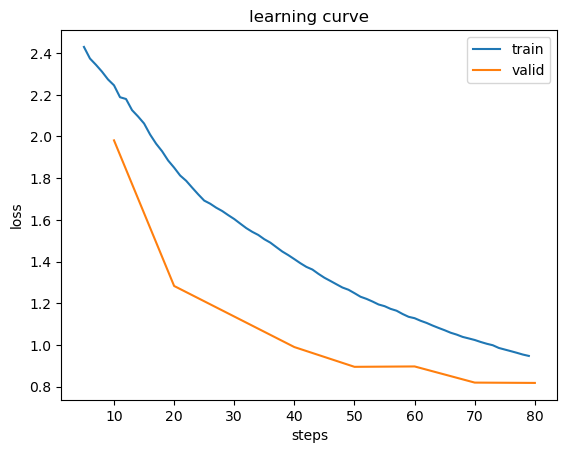

In [3]:
loss_func = CrossEntropyLossFlat(axis=1)
test_loss(loss_func)
